In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import random
pd.options.display.max_columns = 30
import matplotlib.pyplot as plt

In [2]:
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来显示正常中文标签
df = pd.read_csv('Seattle_Hotels.csv', encoding='latin-1')
# 数据探索
print(df.head())
print('数据集中的酒店个数: ', len(df))

name  \
0  Hilton Garden Seattle Downtown   
1          Sheraton Grand Seattle   
2   Crowne Plaza Seattle Downtown   
3   Kimpton Hotel Monaco Seattle    
4              The Westin Seattle   

                                           address  \
0  1821 Boren Avenue, Seattle Washington 98101 USA   
1   1400 6th Avenue, Seattle, Washington 98101 USA   
2                  1113 6th Ave, Seattle, WA 98101   
3                   1101 4th Ave, Seattle, WA98101   
4   1900 5th Avenue, Seattle, Washington 98101 USA   

                                                desc  
0  Located on the southern tip of Lake Union, the...  
1  Located in the city's vibrant core, the Sherat...  
2  Located in the heart of downtown Seattle, the ...  
3  What?s near our hotel downtown Seattle locatio...  
4  Situated amid incredible shopping and iconic a...  
数据集中的酒店个数:  152


In [3]:
def print_description(index):
    example = df[df.index == index][['desc', 'name']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Name: ',example[1])
print('第10个酒店的描述: ')
print_description(10)

第10个酒店的描述: 
Soak up the vibrant scene in the Living Room Bar and get in the mix with our live music and DJ series before heading to a memorable dinner at TRACE. Offering inspired seasonal fare in an award-winning atmosphere, it's a not-to-be-missed culinary experience in downtown Seattle. Work it all off the next morning at FIT®, our state-of-the-art fitness center before wandering out to explore many of the area's nearby attractions, including Pike Place Market, Pioneer Square and the Seattle Art Museum. As always, we've got you covered during your time at W Seattle with our signature Whatever/Whenever® service - your wish is truly our command.
Name:  W Seattle


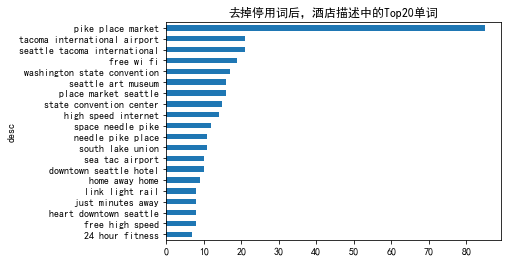

In [4]:
# 得到酒店描述中n-gram特征中的TopK个
def get_top_n_words(corpus, n=1, k=None):
    # 统计ngram词频矩阵
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    """
    print('feature names:')
    print(vec.get_feature_names())
    print('bag of words:')
    print(bag_of_words.toarray())
    """
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # 按照词频从大到小排序
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:k]
common_words = get_top_n_words(df['desc'], 3, 20)
# print(common_words)
df1 = pd.DataFrame(common_words, columns=['desc', 'count'])
df1.groupby('desc').sum()['count'].sort_values().plot(kind='barh', title='去掉停用词后，酒店描述中的Top20单词')
plt.show()

In [5]:
# 文本预处理
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
# 对文本进行清洗
def clean_text(text):
    # 全部小写
    text = text.lower()
    # 用空格替代一些特殊符号, 如标点
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    # 移除BAD_SYMBOLS_RE
    text = BAD_SYMBOLS_RE.sub('', text)
    # 从文本中去掉停用词
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
# 对desc字段进行清理
df['desc_clean'] = df['desc'].apply(clean_text)
# print(df['desc_clean'])

In [6]:
# 建模
df.set_index('name', inplace=True)
# 使用TF-IDF提取文本特征
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.01, stop_words='english')

In [7]:
tfidf_matrix = tf.fit_transform(df['desc_clean'])
print('TFIDF feature names:')
# print(tf.get_feature_names())
print(len(tf.get_feature_names()))
# print('tfidf_matrix:')
# print(tfidf_matrix)
# print(tfidf_matrix.shape)
# 计算酒店之间的余弦相似度(线性核函数)
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
# print(cosine_similarties)
# print(cosine_similarties.shape)
indices = pd.Series(df.index) #df.index是酒店名称

TFIDF feature names:
3154


In [8]:
# 基于相似度矩阵和指定的酒店name，推荐TOP10酒店
def recommendations(name, cosine_similarities = cosine_similarities):
    recommended_hotels = []
    # 找到想要查询酒店名称的idx
    idx = indices[indices == name].index[0]
    print('idx=', idx)
    # 对于idx酒店的余弦相似度向量按照从大到小进行排序
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending = False)
    # 取相似度最大的前10个（除了自己以外）
    top_10_indexes = list(score_series.iloc[1:11].index)
    # 放到推荐列表中
    for i in top_10_indexes:
        recommended_hotels.append(list(df.index)[i])
    return recommended_hotels

In [9]:
print(recommendations('Hilton Seattle Airport & Conference Center'))
print(recommendations('The Bacon Mansion Bed and Breakfast'))
#print(result)

idx= 49
['Embassy Suites by Hilton Seattle Tacoma International Airport', 'DoubleTree by Hilton Hotel Seattle Airport', 'Seattle Airport Marriott', 'Motel 6 Seattle Sea-Tac Airport South', 'Knights Inn Tukwila', 'Four Points by Sheraton Downtown Seattle Center', 'Radisson Hotel Seattle Airport', 'Hampton Inn Seattle/Southcenter', 'Home2 Suites by Hilton Seattle Airport', 'Red Lion Hotel Seattle Airport Sea-Tac']
idx= 116
['11th Avenue Inn Bed and Breakfast', 'Shafer Baillie Mansion Bed & Breakfast', 'Gaslight Inn', 'Bed and Breakfast Inn Seattle', 'Chittenden House Bed and Breakfast', 'Hyatt House Seattle', 'Mozart Guest House', 'Silver Cloud Hotel - Seattle Broadway', 'WorldMark Seattle - The Camlin', 'Pensione Nichols Bed and Breakfast']
